### Importing libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle


### Mounting Drive

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


### Download and prepare MSCOCO Dataset

In [ ]:
#path to read the dataset from the shared drive
#shared_path ='/content/drive/Shareddrives/Project_258_dataset/'
shared_path ='.'

annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                          cache_subdir=os.path.abspath(shared_path),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
#annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
annotation_file='/content/drive/Shareddrives/Project_258_dataset/annotations/captions_train2014.json'


252878848/252872794 [==============================] - 6s 0us/step


In [ ]:
name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath(shared_path) + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, cache_subdir=os.path.abspath(shared_path),origin = 'http://images.cocodataset.org/zips/train2014.zip',extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
 #PATH = os.path.abspath(shared_path)+'/train2014/'
 PATH='/content/drive/Shareddrives/Project_258_dataset/train2014/'

13510574080/13510573713 [==============================] - 354s 0us/step


In [ ]:
print(PATH)

/content/train2014/


In [ ]:
# read the json annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
print(annotations)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start> ' + annot['caption'] + ' <end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
all_img_name_vector,
random_state=1)

# selecting the first 40000 captions 
num_examples = 8000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
#image_name_vector is a list variable having all paths stored in it.
#train_captions is having associated captions

print(img_name_vector)
print(train_captions)

['/content/train2014/COCO_train2014_000000324909.jpg', '/content/train2014/COCO_train2014_000000511972.jpg', '/content/train2014/COCO_train2014_000000508809.jpg', '/content/train2014/COCO_train2014_000000270497.jpg', '/content/train2014/COCO_train2014_000000008014.jpg', '/content/train2014/COCO_train2014_000000269577.jpg', '/content/train2014/COCO_train2014_000000527748.jpg', '/content/train2014/COCO_train2014_000000109008.jpg', '/content/train2014/COCO_train2014_000000339535.jpg', '/content/train2014/COCO_train2014_000000425647.jpg', '/content/train2014/COCO_train2014_000000013797.jpg', '/content/train2014/COCO_train2014_000000556033.jpg', '/content/train2014/COCO_train2014_000000092221.jpg', '/content/train2014/COCO_train2014_000000449154.jpg', '/content/train2014/COCO_train2014_000000016099.jpg', '/content/train2014/COCO_train2014_000000326347.jpg', '/content/train2014/COCO_train2014_000000500190.jpg', '/content/train2014/COCO_train2014_000000059641.jpg', '/content/train2014/COCO_tr

###CNN Encoder to extract features from images

#### Using Inception V3 pretrained model on imagenet

In [ ]:
# this is to preprocess the image in the format that is expected by inception v3 model
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

In [ ]:
# this model will extract features from the images : CNN Encoder
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

#### Saving images in the format of numpy array

In [ ]:
#runnig for each image in the dataset and extracting features using CNN 
encode_train = sorted(set(img_name_vector))
#Load images in batches
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train).map(load_image).batch(16)

#Extract features
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

#Dump features in the format of numoy array
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


In [ ]:
batch_features

<tf.Tensor: shape=(4, 64, 2048), dtype=float32, numpy=
array([[[0.        , 0.84239465, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 1.0204202 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.859296  , 0.21095051, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.24829388, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.02911363]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         1.129814  , 0.        ],
        [0.        , 0.07968863, 0.        , ..., 0.        ,
         0.88732433, 0.        ],
        [0.        , 0.31156746, 0.        , ..., 0.        ,
         0.89515907, 0.        ],
        ...,
        [0.        , 1.5149931 , 0.24871379, ..., 0.4

### RNN Decoder for Language generation

#### Tokens converted into integer sequence

In [ ]:
def maxLength(tensor):
  return max(len(t) for t in tensor)

# Performing tokenization on captions to create vocabulary of 5000 words
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# text is converted into sequence of numbers
tokenizer.fit_on_texts(train_captions) # Updates internal vocabulary based on a list of texts.
train_seqs = tokenizer.texts_to_sequences(train_captions) #with its corresponding integer value from the word_index dictionary

tokenizer.word_index = {key:value for key, value in tokenizer.word_index.items() if value <= top_k}

# putting <unk> token in the word2idx dictionary
tokenizer.word_index[tokenizer.oov_token] = top_k + 1
tokenizer.word_index['<pad>'] = 0

# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# creating a reverse mapping (index -> word)
index_word = {value:key for key, value in tokenizer.word_index.items()}

# padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# calculating the max_length 
# used to store the attention weights
max_length = maxLength(train_seqs)

In [ ]:
# split data into 80:20 ratio
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector,test_size=0.2,random_state=0)


In [ ]:
# Defining parameters for training
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)

#### Creating dataset from images features and tokenized captions

In [ ]:
# features extracted from inception V3 (64, 2048)
features_shape = 2048
attention_features_shape = 64

# loading the image features saved as numpy array 
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

#converting raw data into tensor slices
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=8)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

In [ ]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [ ]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, features, hidden):
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.units)
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units)) 

In [ ]:

print("Loading Encoder")
encoder = CNN_Encoder(embedding_dim)
print("Loading Decoder")
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.optimizers.Adam()


checkpoint_dir = './my_model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder,)

Loading Encoder
Loading Decoder
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

### Training

In [ ]:
#using teacher forcing which is a method for quickly and efficiently training recurrent neural
#network models that use the ground truth from a prior time step as input.
EPOCHS = 20
loss_plot = []
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss += (loss / int(target.shape[1]))

    variables = encoder.variables + decoder.variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables), tf.compat.v1.train.get_or_create_global_step(graph=None))

    if batch % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, 
      batch, 
      loss.numpy() / int(target.shape[1])))
      # storing the epoch end loss value to plot later
  loss_plot.append(total_loss / len(cap_vector))

  print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/len(cap_vector)))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9894
Epoch 1 Loss 0.015630
Time taken for 1 epoch 119.06381154060364 sec

Epoch 2 Batch 0 Loss 1.0390
Epoch 2 Loss 0.012684
Time taken for 1 epoch 100.08022904396057 sec

Epoch 3 Batch 0 Loss 0.9392
Epoch 3 Loss 0.011079
Time taken for 1 epoch 92.68607425689697 sec

Epoch 4 Batch 0 Loss 0.8186
Epoch 4 Loss 0.010003
Time taken for 1 epoch 95.76140093803406 sec

Epoch 5 Batch 0 Loss 0.7001
Epoch 5 Loss 0.009199
Time taken for 1 epoch 96.17262506484985 sec

Epoch 6 Batch 0 Loss 0.7134
Epoch 6 Loss 0.008555
Time taken for 1 epoch 95.98803853988647 sec

Epoch 7 Batch 0 Loss 0.6083
Epoch 7 Loss 0.007984
Time taken for 1 epoch 95.84911775588989 sec

Epoch 8 Batch 0 Loss 0.6092
Epoch 8 Loss 0.007422
Time taken for 1 epoch 95.41636419296265 sec

Epoch 9 Batch 0 Loss 0.6073
Epoch 9 Loss 0.006908
Time taken for 1 epoch 95.51172924041748 sec

Epoch 10 Batch 0 Loss 0.4965
Epoch 10 Loss 0.006384
Time taken for 1 epoch 95.54361176490784 sec

Epoch 11 Batch 0 Loss 0.4667
Epoch 1

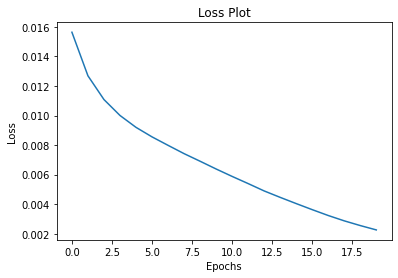

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Testing

In [ ]:
def caption(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

      attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

      predicted_id = tf.argmax(predictions[0]).numpy()
      result.append(index_word[predicted_id])

      if index_word[predicted_id] == '<end>':
        return result, attention_plot

      dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

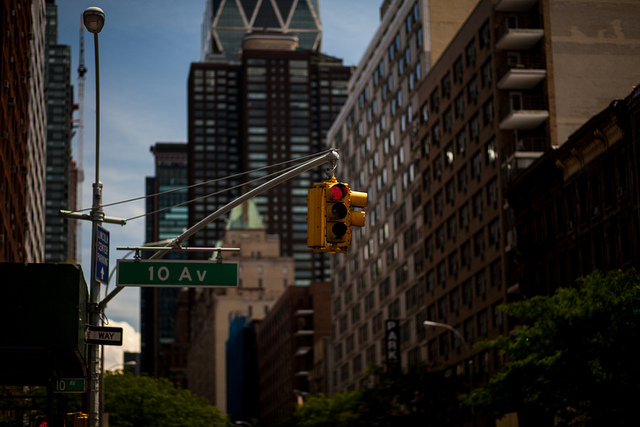

In [ ]:
image_url = '/content/drive/Shareddrives/Project_258_dataset/train_dataset/test1.jpg'
image_extension = image_url[-4:]
image_path = image_url
Image.open(image_path)

Prediction Caption: town is shown on it <end>


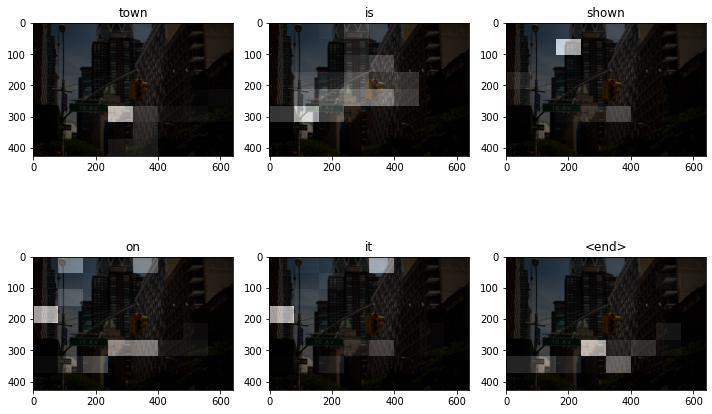

In [ ]:
result, attention_plot = caption(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

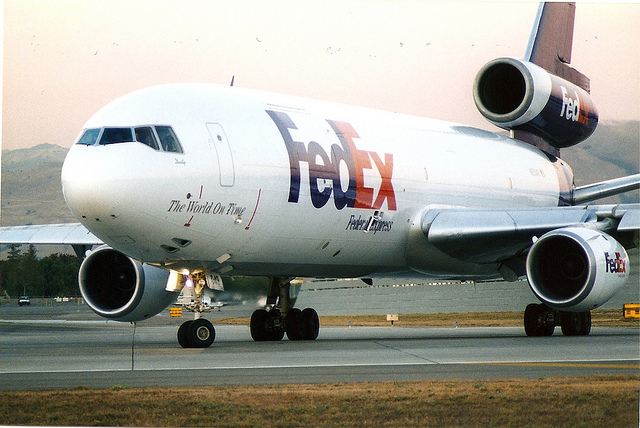

In [ ]:
image_url = '/content/drive/Shareddrives/Project_258_dataset/train_dataset/test10.jpg'
image_extension = image_url[-4:]
image_path = image_url
Image.open(image_path)

Prediction Caption: a jumbo jet off <end>


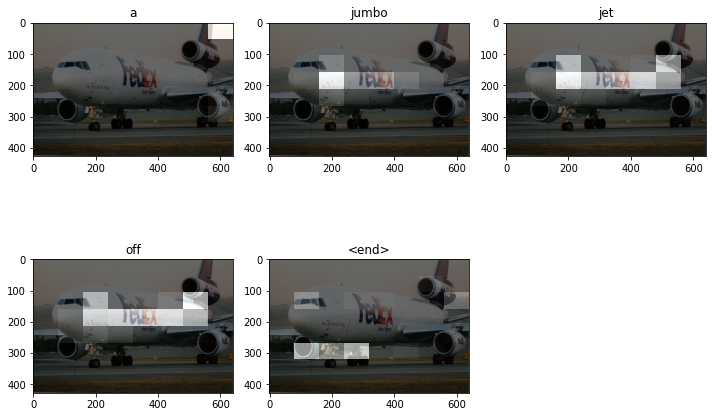

In [ ]:
result, attention_plot = caption(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

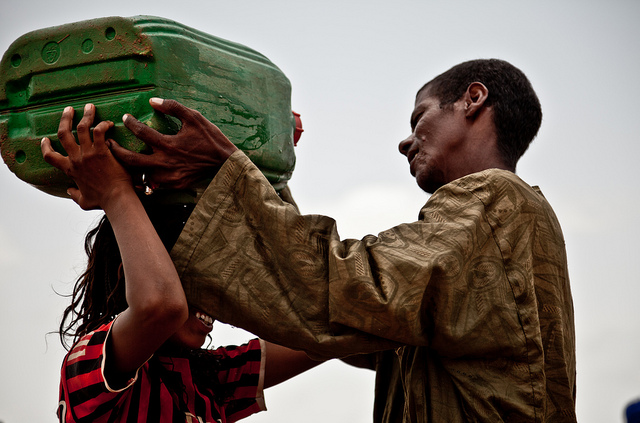

In [ ]:
image_url = '/content/drive/Shareddrives/Project_258_dataset/train_dataset/test11.jpg'
image_extension = image_url[-4:]
image_path = image_url
Image.open(image_path)

Prediction Caption: a bull bull smile <end>


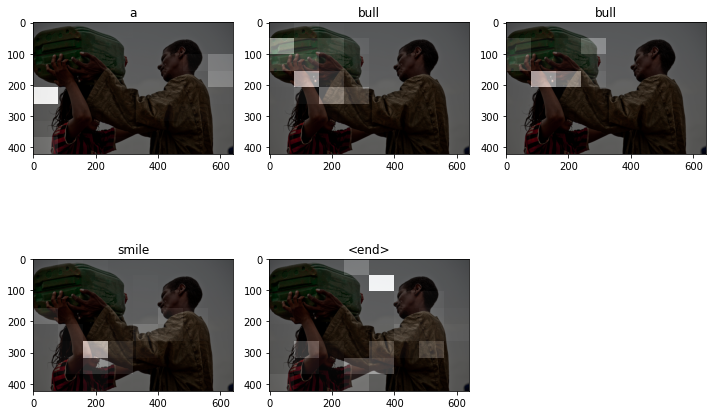

In [ ]:
result, attention_plot = caption(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)